**Name:** Alex Medina

**Organization:** University of Central Florida

**Project Title:** Lightcurve Analysis of Titan

**Subsection:** Model Results

**Details:** Having gathered both observational and model results, it is now time to compare the results. For the observational results, I have a single set of data points for each of the four wavelengths. For the model, however, I have over 100 different results, with similar imputs, just varying radii and variance. For 66 of the points, I used log normal law and for the other 66 I used two parameter gamma. *Logic:* I am not too familiar with modes off erro analysis, I've seen chi squared but I'm gonna try this numerically first for my understanding, each observation point has a phase angle but it is usually to the third decimal, while the results files are named according to a whole phase angle. First, I want to round the phase angles in the observational data set to the closest integer(our X axis), then compare the Q values (Y axis) of the model and the observation at the respective phase angle, denoting this difference in Q as the difference (error may be more appropriate). Then, find the average difference across all wavelengths for a single model, and the lowest average must be the best fitting model. I will find the best overall model, and then the best model per wavelength.

In [45]:
#General imports
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Observational Data

In [46]:
#I've copied the results from the polarization phase curve into .csv files in a folder on my desktop
obs_folder = r'C:\Users\Alex\Desktop\DAP_output\OBS_results'


#Wavlengths
wavTitan = [0.4410, 0.5690, 0.6190, 0.7500]
#Files with observational results
#Have columns directly names after polarization code output
#filename, phase_angles, scat_q, scat_u, scat_qi, scat_ui
obs_files = ['obs_0441.csv', 'obs_0569.csv', 'obs_0619.csv', 'obs_0750.csv']
stokes_parameter = 'Q'
#DAP doesn't explicitly title I, Q, U, but naming convention will be Q (alternative test code)
#Can change to U or I as needed (I will need a different obs_files, though)
obs_col = 'scat_q' if stokes_parameter == 'Q' else 'scat_u'

#DAP results are in even integers for phase angles
def obs_to_even(x):
    return int(2 * round(x / 2))

#Loading observational data and rounding the phase angles
obs_data = {}
for wl, fname in zip(wavTitan, obs_files):
    df = pd.read_csv(os.path.join(obs_folder, fname))
    #Phase angles are written to the second decimal point, rounding the the nearest integer
    df['rounded_phase'] = df['phase_angles'].apply(obs_to_even)
    #df['rounded_phase'] = df['phase_angles'].round().astype(int) 
    #Only need the phase angle and Q (tuple for the dictionary)
    obs_data[wl] = df[['rounded_phase', obs_col]]

Model Data

In [47]:
#I've saved the model results in folders on my desktop
#Copied from my linux subsystem (Windows)
mod_folder = r'C:\Users\Alex\Desktop\DAP_output' 

#Function to parse a single model folder
def pmod_folder(folder_path):
    #The files in the DAP output are organized by phase in file name (i.e., 024.0000.dat)
    #For each phase file, there is rows correseponding to wavelength
    #And columns correspond to what I believe to be I, Q, U
    model_data = {wl: {} for wl in wavTitan}
    #{wl: {'phase': [], 'I': [], 'Q': [], 'U': []} for wl in wavTitan}
    for filename in sorted(os.listdir(folder_path)):
        #Only the .00000.dat files are the ones need
        #DAP outputs more that I don't need
        if filename.endswith(".00000.dat"):
            #Phase angle from the filename
            phase_angle = int(filename.split('.')[0])
            with open(os.path.join(folder_path, filename), 'r') as file:
                #Reading each line in the file because it's a string like
                #"0.4410  0.492397E+00  0.000000E+00  -.00000000"
                for line in file:
                    #Removing blank space and splitting into substrings
                    #['0.4410', '0.492397E+00', '0.000000E+00, '-.00000000']
                    parts = line.strip().split()
                    
                    #Converting string to number (float) accorindgly
                    wl = float(parts[0])
                    if wl in wavTitan:
                        value = float(parts[2]) if stokes_parameter == 'Q' else float(parts[3])
                        model_data[wl][phase_angle] = value
    return model_data

Difference Analysis

In [48]:
#Computing the difference between the model and the observational data

def obsmod_diff(model_data, obs_data):
    #Outer dictionary to store the mean difference per wavelength
    wl_diffs = {}
    for wl in wavTitan:
        obs_df = obs_data[wl]
        #model_dict will be the model data which stores the Q value according to phase angle index
        model_dict = model_data[wl]
        #Inner list to store per-phase differences
        phase_diffs = []
        #Iterate over obs_df, returning (index, row)
        for _, row in obs_df.iterrows():
            #From obs.csv
            phase = row['rounded_phase']
            obs_val = row[obs_col]
            #Matching phases
            #Should work well since we have even rounded phases
            if phase in model_dict:
                #Finding the corresponing Q value for model
                model_val = model_dict[phase]
                #Calculating difference and storing it into an array
                phase_diffs.append(abs(model_val - obs_val))
        wl_diffs[wl] = np.mean(phase_diffs) if phase_diffs else np.nan
        #Overall model difference
    overall_diff = np.nanmean(list(wl_diffs.values()))
    return wl_diffs, overall_diff

In [49]:
#We can run the function and testing shows that it works to give a value, but now I need to run it for all models
#Because while we compare model to observation, I also compare model to model
#Model score I simply define as the average of the difference
#The lower the average, the better the score because closer values on average to the observation

model_scores = []
bmod_per_wl = {wl: {'Model': None, 'Difference': float('inf')} for wl in wavTitan}

for folder in os.listdir(mod_folder):
    folder_path = os.path.join(mod_folder, folder)
    #ONLY choosing the folders in the DAP results folder that start with PL_titan_ or OUT_titan_
    if os.path.isdir(folder_path) and folder.startswith('PL_titan_'):
        #Parse single folder at a time
        model_data = pmod_folder(folder_path)
        #Input to calcualte difference with obs_data
        wl_diffs, overall_diff = obsmod_diff(model_data, obs_data)

        #To keep track of the best model per wavelength
        for wl in wavTitan:
            diff = wl_diffs[wl]
            if not np.isnan(diff) and diff < bmod_per_wl[wl]['Difference']:
                bmod_per_wl[wl] = {'Model': folder, 'Difference': diff}

        #Scores (averages values)
        model_scores.append({
            'Model': folder,
            'Model_AVG_diff': overall_diff,
            'Wavelength_AVG_diff': wl_diffs
        })

Model Scores

In [50]:
#Sorting the models by score
model_scores.sort(key=lambda x: x['Model_AVG_diff'])

print("Best Models:")
for i, result in enumerate(model_scores[:5]):
    print(f"Rank {i+1}: {result['Model']}")
    print(f"Overall Average Difference: {result['Model_AVG_diff']:.4f}")
    #for wl in wavTitan:
    #    diff = result['Wavelength_AVG_diff'][wl]
    #    print(f"{wl:.4f} μm → Difference: {diff:.4f}")

print("Best Models per Wavelength:")
for wl in wavTitan:
    best = bmod_per_wl[wl]
    print(f"{wl:.4f} μm → {best['Model']} (Difference: {best['Difference']:.4f})")


Best Models:
Rank 1: PL_titan_7
Overall Average Difference: 0.0029
Rank 2: PL_titan_17
Overall Average Difference: 0.0035
Rank 3: PL_titan_26
Overall Average Difference: 0.0047
Rank 4: PL_titan_34
Overall Average Difference: 0.0058
Rank 5: PL_titan_40
Overall Average Difference: 0.0062
Best Models per Wavelength:
0.4410 μm → PL_titan_7 (Difference: 0.0020)
0.5690 μm → PL_titan_17 (Difference: 0.0017)
0.6190 μm → PL_titan_40 (Difference: 0.0016)
0.7500 μm → PL_titan_7 (Difference: 0.0037)


Best Models Visualized

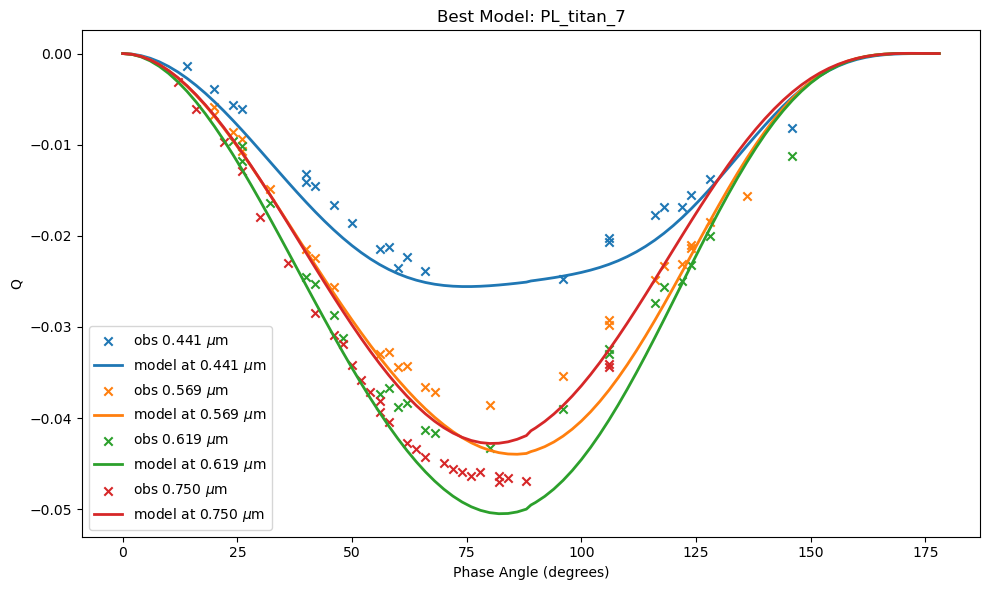

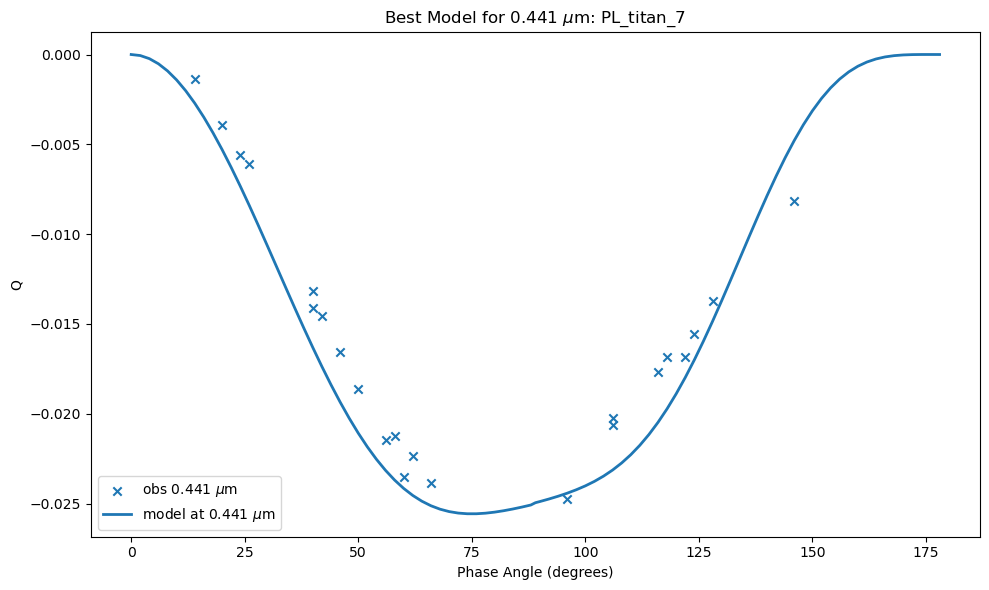

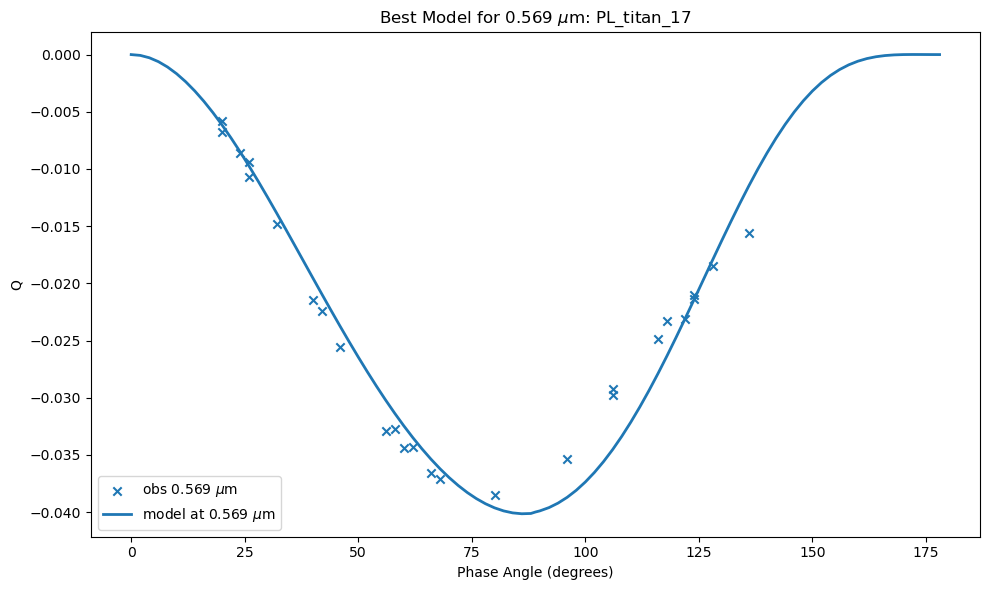

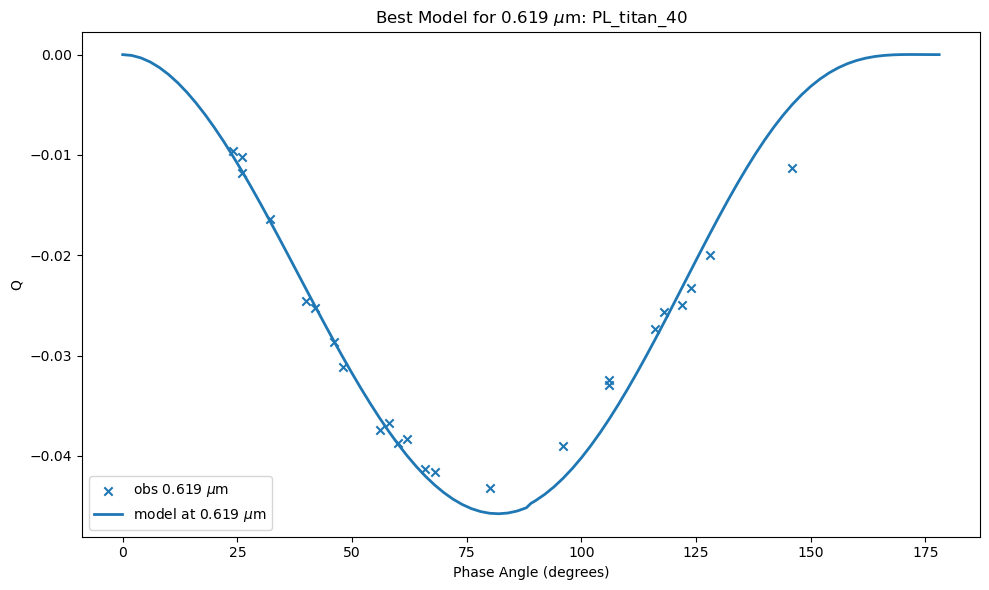

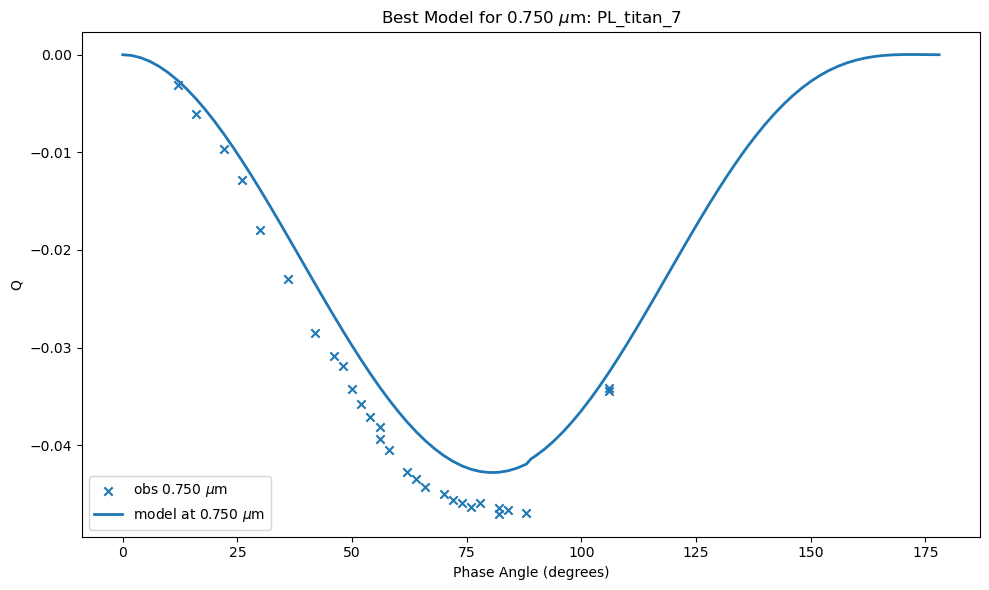

In [51]:
#To plot, we just need the best folders, but not a for loop
def load_modplot(folder_name):
    folder_path = os.path.join(mod_folder, folder_name)
    return pmod_folder(folder_path)

#Plot inputs overall
model_name_o = model_scores[0]['Model']
model_data = load_modplot(model_name_o)

plt.figure(figsize=(10, 6))
for wl in wavTitan:

    #Model and obs data
    model_vals = model_data[wl]
    obs_df = obs_data[wl]

    #Scatter for the observational
    plt.scatter(obs_df['rounded_phase'], obs_df[obs_col], label=rf'obs {wl:.3f} $\mu$m', marker='x')
    #Line graph for the model
    phases = sorted(model_vals.keys())
    values = [model_vals[p] for p in phases]
    plt.plot(phases, values, label=rf'model at {wl:.3f} $\mu$m', linewidth=2)

plt.title(f'Best Model: {model_name_o}')
plt.xlabel('Phase Angle (degrees)')
plt.ylabel(stokes_parameter)
plt.legend()
plt.tight_layout()
plt.show()

#Plot inputs (per wavelength)
for wl in wavTitan:

    #Getting individuals instead of overall
    model_name_wl = bmod_per_wl[wl]['Model']
    model_data = load_modplot(model_name_wl)

    #Model and obs data
    model_vals = model_data[wl]
    obs_df = obs_data[wl]
    
    #Plot all 1 by 1 (above its all on same figure)
    plt.figure(figsize=(10, 6))
    #Scatter for observational
    plt.scatter(obs_df['rounded_phase'], obs_df[obs_col], label=rf'obs {wl:.3f} $\mu$m', marker='x')
    #Line graph for model
    phases = sorted(model_vals.keys())
    values = [model_vals[p] for p in phases]
    plt.plot(phases, values, label=rf'model at {wl:.3f} $\mu$m', linewidth=2)
    
    plt.title(rf'Best Model for {wl:.3f} $\mu$m: {model_name_wl}')
    plt.xlabel('Phase Angle (degrees)')
    plt.ylabel(stokes_parameter)
    plt.legend()
    plt.tight_layout()
    plt.show()